### Unsupervised Analysis of Congressional Laws

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.cluster import KMeans
from sklearn.decomposition import (NMF,
                                   TruncatedSVD)
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

__Import data__

In [25]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)

In [26]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

__Import Law Summary Data__

In [27]:
laws_summaries = pd.read_csv('laws_summary.csv')

__ Import Custom Stop Words__

In [28]:
custom_stopwords_df = pd.read_csv('custom_stopwords_more.csv')
custom_sw = frozenset(custom_stopwords_df.iloc[:,1])

In [29]:
custom_sw

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'amended',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'ante',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'april',
           'are',
           'around',
           'as',
           'at',
           'august',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',

## NMF

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words = custom_sw, 
                                   token_pattern="\\b[a-z][a-z]{2,100}\\b",
                                   max_df = 0.90,
                                   min_df = 50)

In [31]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [32]:
dtm

<3896x16774 sparse matrix of type '<class 'numpy.float64'>'
	with 2398375 stored elements in Compressed Sparse Row format>

In [33]:
num_groups = 20
nmf_model = NMF(num_groups )
dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [34]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: post office post facility service located postal facility united postal service states postal reference located office references office approved service office note office designation states facility facility referred designate facility designation facility street

Topic: 1
Keywords: health secretary state program shall services fiscal research year education care information fiscal year secretary shall grant programs report including assistance federal

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse note courthouse references courthouse approved courthouse referred street designate united reference designation united assembled designation infrastructure congressional comm transportation states united located act designate regulation document reference law map regulation

Topic: 3
Keywords: land secretary conveyance forest federal land county national forest 

__Investigate whether Topics identified match title__

In [35]:
def rank_df(df,rank,num_groups):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [36]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

rank_df(nmf_df,1,num_groups)
rank_df(nmf_df,2,num_groups)
rank_df(nmf_df,3,num_groups)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

nmf_df = nmf_df.merge(laws_summaries[['id',
                                      'title',
                                      'sponsor_party',
                                      'sponsor_state',
                                      'congress']],on = 'id',how = 'left')

In [37]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
1339,c108publ283,S.2264 - Northern Uganda Crisis Response Act 108th Congress (2003-2004),16,17,16
1815,c109publ263,H.R.5245 - To designate the facility of the United States Postal Service located at 1 Marble Str...,7,0,14
1519,c108publ445,S.2484 - Department of Veterans Affairs Health Care Personnel Enhancement Act of 2004 ...,19,6,1
3154,c112publ276,S.3331 - Intercountry Adoption Universal Accreditation Act of 2012 112th Congres...,19,1,19
1068,c107publ39,S.J.Res.22 - A joint resolution expressing the sense of the Senate and House of Representatives ...,17,4,4
839,c107publ172,S.1094 - Hematological Cancer Research Investment and Education Act of 2002 107t...,1,4,1
3872,c115publ15,S.305 - Vietnam War Veterans Recognition Act of 2017 115th Congress (2017-2018) ...,6,17,13
1102,c107publ7,H.R.395 - To designate the facility of the United States Postal Service located at 2305 Minton R...,0,7,12
798,c107publ135,H.R.3447 - Department of Veterans Affairs Health Care Programs Enhancement Act of 2001 ...,6,1,1
588,c105publ329,S.2106 - Arches National Park Expansion Act of 1998 105th Congress (1997-1998),3,13,13


## TSNE Visualization (NMF)

In [38]:
np.shape(dtm_nmf)

(3896, 20)

In [39]:
tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  early_exaggeration=4.0,
                  n_iter=5000,
                  verbose=2,
                  random_state = 101)

tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.067569
[t-SNE] Iteration 25: error = 1.7235702, gradient norm = 0.0004160
[t-SNE] Iteration 25: gradient norm 0.000416. Finished.
[t-SNE] Iteration 50: error = 1.5569376, gradient norm = 0.0077215
[t-SNE] Iteration 75: error = 1.4538246, gradient norm = 0.0057102
[t-SNE] Iteration 100: error = 1.4307656, gradient norm = 0.0054054
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.430766
[t-SNE] Iteration 125: error = 1.2815262, gradient norm = 0.0037218
[t-SNE] Iteration 150: error = 1.2355478, gradient norm = 0.0033761
[t-SNE] Iteration 175: error = 1.2242079, gradient norm = 0.0033110
[t-SNE] Iteration 

In [61]:
tsne_df = pd.DataFrame(tsne_nmf,columns=['tsne_x','tsne_y'])
tsne_df['robo_group'] = nmf_df['MAX1']
tsne_df['title'] = nmf_df['title']

In [63]:
tsne_df.to_csv('tsne_data_attemp1.csv')

Color by Topic

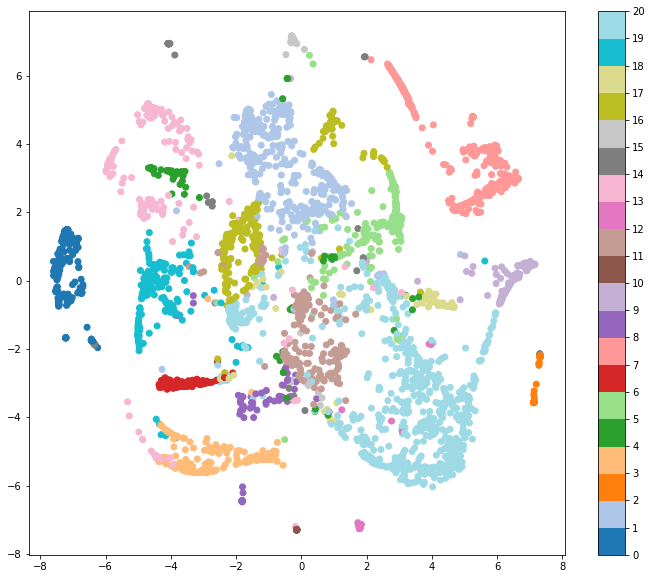

In [40]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=nmf_df.MAX1, 
            cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num_groups)
plt.show()

Color by Party

In [41]:
c_bar_party = nmf_df['sponsor_party']

m_dict = {'D':0,'R':1}
c_bar_party = c_bar_party.map(m_dict)

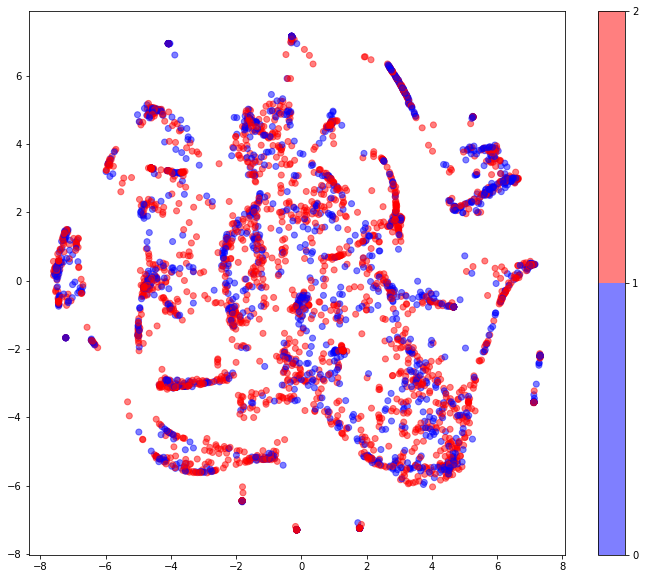

In [47]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=c_bar_party, 
            cmap=plt.cm.get_cmap("bwr", 2),
           alpha = 0.5)
plt.colorbar(ticks=range(2+1))
plt.clim(0, 2)
plt.show()

Color by state of sponsoring congress person

In [43]:
states = laws_summaries['sponsor_state'].unique()

states_dict = dict()
for ix, s in enumerate(states):
    states_dict[s] = ix
    
num_states = ix + 1

c_bar_state = nmf_df['sponsor_state']
c_bar_state = c_bar_state.map(states_dict)

states_df = pd.DataFrame(list(states_dict.items()),columns=['states','num'])

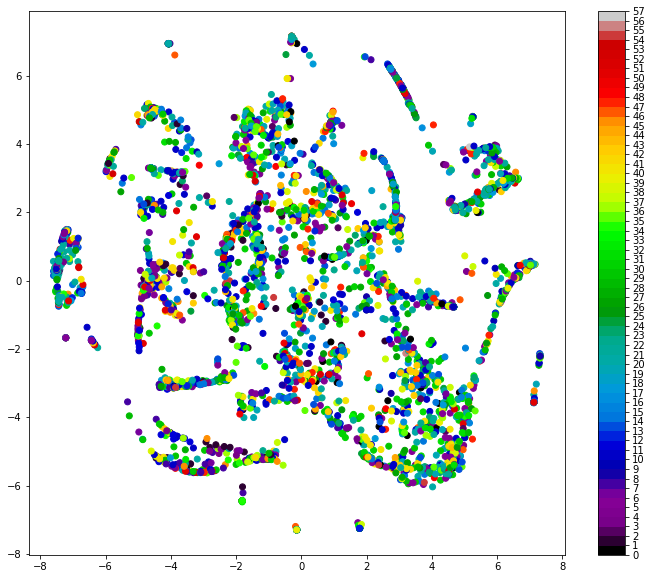

<function matplotlib.pyplot.colorbar>

In [44]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_state, 
            cmap=plt.cm.get_cmap("nipy_spectral", num_states))
plt.colorbar(ticks=range(num_states+1))
plt.clim(0, num_states)
plt.show()

plt.colorbar

Color by congressional sessions chronologically

In [45]:
congress = laws_summaries['congress'].unique()

congress_dict = dict()
for ix, c in enumerate(congress):
    congress_dict[c] = ix
    
num_congress = ix + 1

c_bar_congress = nmf_df['congress']
c_bar_congress = c_bar_congress.map(congress_dict)

congress_df = pd.DataFrame(list(congress_dict.items()),columns=['congress','num'])

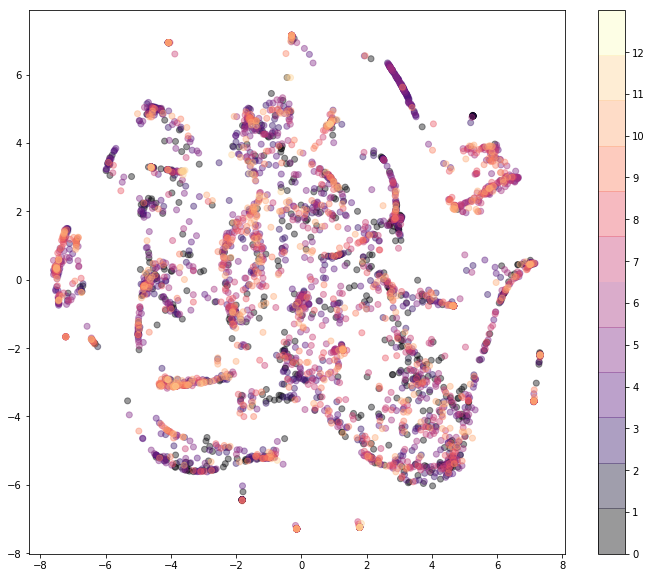

<function matplotlib.pyplot.colorbar>

In [46]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_congress, 
            cmap=plt.cm.get_cmap("magma", num_congress),
            alpha = 0.4)
plt.colorbar(ticks=range(num_congress+1))
plt.clim(0, num_congress+1)
plt.show()

plt.colorbar